In [39]:
# Data Processing and Visualization
import os                  # Operating system-specific functionalities
import random              # Generates pseudo-random numbers
import glob                # Finds all the pathnames matching a specified pattern
import re                  # Regular expression operations

# Data Manipulation and Analysis
import numpy as np         # Fundamental package for scientific computing with Python
import pandas as pd        # Data manipulation and analysis library

# Image Processing and Visualization
import matplotlib.pyplot as plt   # Data visualization library
import cv2                        # OpenCV for image processing
from skimage import io            # Image I/O library from scikit-image

# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf                     # Open-source machine learning library
from tensorflow.keras.layers import (       # Keras layers for building neural networks
    Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
)
from tensorflow.keras.models import Model   # Model class for defining neural network models
from tensorflow.keras.applications import VGG16  # Pre-trained VGG16 model

# Specific TensorFlow/Keras Components
from tensorflow.keras import layers, optimizers  # Different components for building and training neural networks
from tensorflow.keras.initializers import glorot_uniform  # Glorot (Xavier) weight initializer
from tensorflow.keras.utils import plot_model  # Utility for plotting model architectures
from tensorflow.keras.callbacks import (  # Callbacks for adjusting learning rate during training
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
)
import tensorflow.keras.backend as K  # Keras backend for low-level operations

# Other Libraries
from sklearn.preprocessing import StandardScaler, normalize  # For data preprocessing
from IPython.display import display  # Display utilities for IPython environments
from keras.models import load_model  # Loading models in Keras
from keras.losses import binary_crossentropy  # Binary cross-entropy loss function


In [40]:
data_map = []

# Specify the path to your dataset on your Windows machine
dataset_path = "datasets/archive/lgg-mri-segmentation/kaggle_3m"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        try:
            dir_name = sub_dir_path.split('/')[-1]

            # Iterate over files in the directory
            for filename in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, filename)
                data_map.extend([dir_name, image_path])
        except Exception as e:
            print(e)

# Display the data_map
print(data_map)


['TCGA_DU_7294_19890104', 'datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_15_mask.tif', 'TCGA_DU_7294_19890104', 'datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_22.tif', 'TCGA_DU_7294_19890104', 'datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_10_mask.tif', 'TCGA_DU_7294_19890104', 'datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_18_mask.tif', 'TCGA_DU_7294_19890104', 'datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_14.tif', 'TCGA_DU_7294_19890104', 'datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_20_mask.tif', 'TCGA_DU_7294_19890104', 'datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_17.tif', 'TCGA_DU_7294_19890104', 'datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_198

In [41]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()


,patient_id,path
0,TCGA_DU_7294_19890104,datasets/archive/lgg-mri-segmentation/kaggle_3...
1,TCGA_DU_7294_19890104,datasets/archive/lgg-mri-segmentation/kaggle_3...
2,TCGA_DU_7294_19890104,datasets/archive/lgg-mri-segmentation/kaggle_3...
3,TCGA_DU_7294_19890104,datasets/archive/lgg-mri-segmentation/kaggle_3...
4,TCGA_DU_7294_19890104,datasets/archive/lgg-mri-segmentation/kaggle_3...


In [42]:
# Filtering image paths
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Creating a dictionary for mask paths
mask_dict = {path[:-9]: path for path in df_masks["path"].values}

# Pairing each image with its corresponding mask
pairs = []
for img_path in df_imgs["path"].values:
    mask_path = mask_dict.get(img_path[:-4])  # Remove the '.tif' from the image path
    if mask_path:
        pairs.append((img_path, mask_path))

# Randomly selecting one pair of image and mask
idx = random.randint(0, len(pairs)-1)
img_path, mask_path = pairs[idx]
print("Path to the Image:", img_path, "\nPath to the Mask:", mask_path)


Path to the Image: datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_28.tif 
Path to the Mask: datasets/archive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_28_mask.tif


In [43]:
# Final dataframe
brain_df = pd.DataFrame(pairs, columns=["image_path", "mask_path"])

# Extract patient_id from image_path
brain_df["patient_id"] = brain_df["image_path"].apply(lambda x: x.split("/")[-2])

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df


,image_path,mask_path,patient_id,mask
0,datasets/archive/lgg-mri-segmentation/kaggle_3...,datasets/archive/lgg-mri-segmentation/kaggle_3...,TCGA_DU_7294_19890104,1
1,datasets/archive/lgg-mri-segmentation/kaggle_3...,datasets/archive/lgg-mri-segmentation/kaggle_3...,TCGA_DU_7294_19890104,0
2,datasets/archive/lgg-mri-segmentation/kaggle_3...,datasets/archive/lgg-mri-segmentation/kaggle_3...,TCGA_DU_7294_19890104,0
3,datasets/archive/lgg-mri-segmentation/kaggle_3...,datasets/archive/lgg-mri-segmentation/kaggle_3...,TCGA_DU_7294_19890104,0
4,datasets/archive/lgg-mri-segmentation/kaggle_3...,datasets/archive/lgg-mri-segmentation/kaggle_3...,TCGA_DU_7294_19890104,0
...,...,...,...,...
3924,datasets/archive/lgg-mri-segmentation/kaggle_3...,datasets/archive/lgg-mri-segmentation/kaggle_3...,TCGA_DU_7008_19830723,1
3925,datasets/archive/lgg-mri-segmentation/kaggle_3...,datasets/archive/lgg-mri-segmentation/kaggle_3...,TCGA_DU_7008_19830723,1
3926,datasets/archive/lgg-mri-segmentation/kaggle_3...,datasets/archive/lgg-mri-segmentation/kaggle_3...,TCGA_DU_7008_19830723,0
3927,datasets/archive/lgg-mri-segmentation/kaggle_3...,datasets/archive/lgg-mri-segmentation/kaggle_3...,TCGA_DU_7008_19830723,1


In [44]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

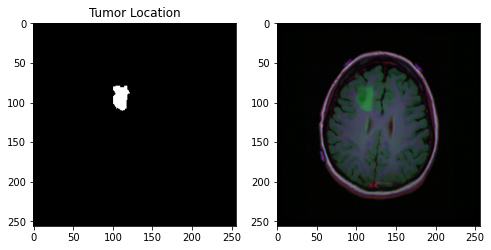

In [45]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [46]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

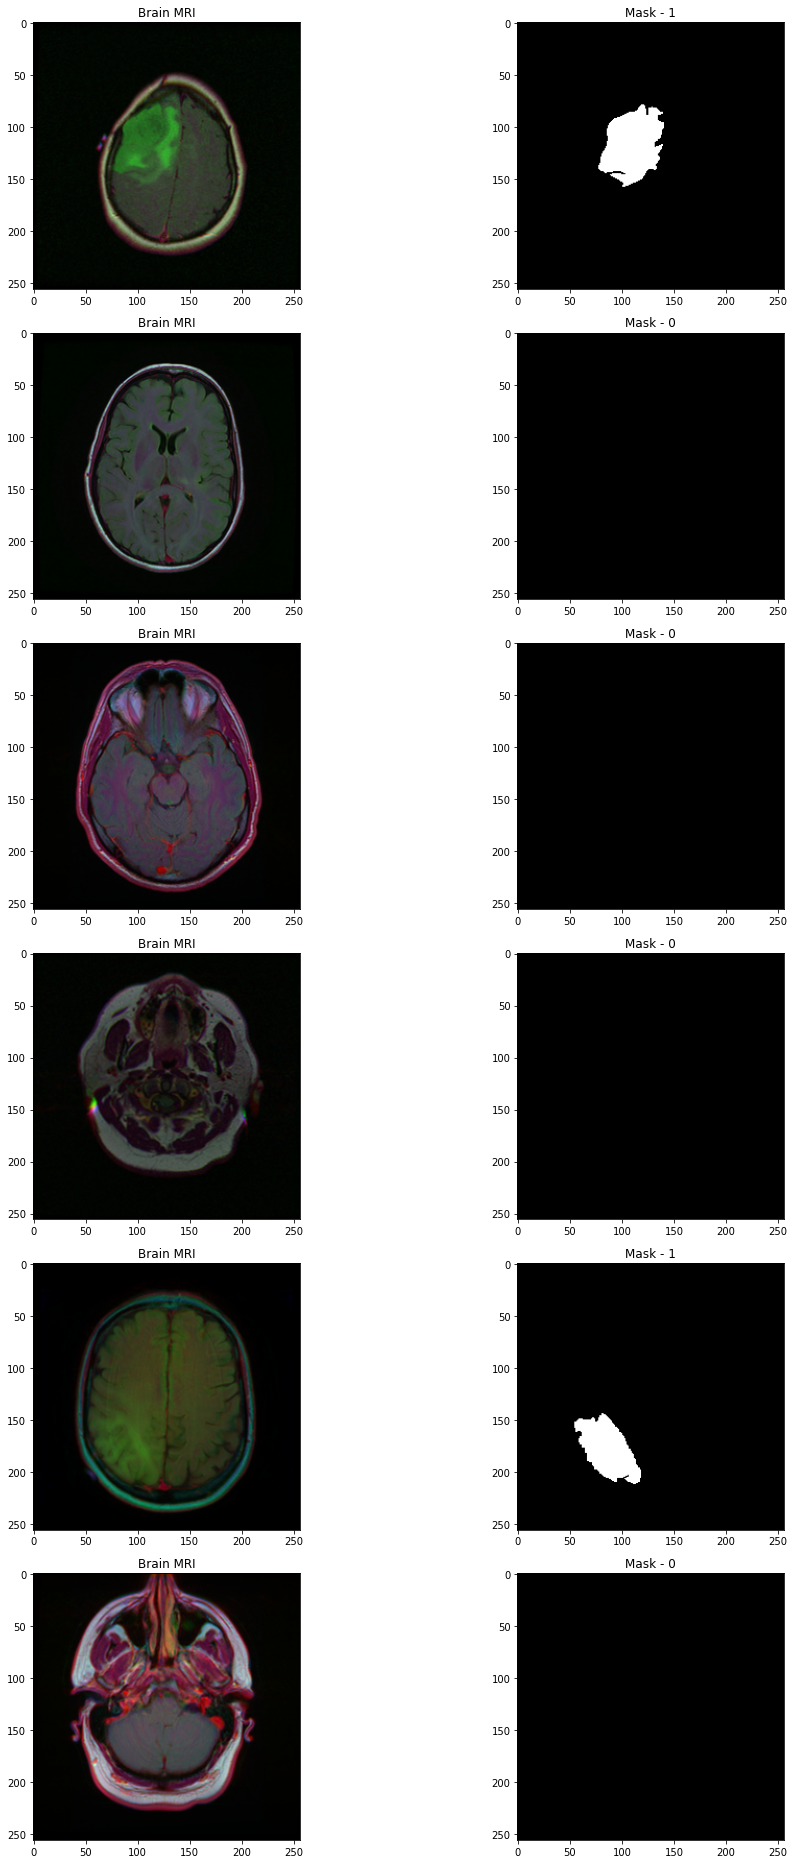

In [47]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

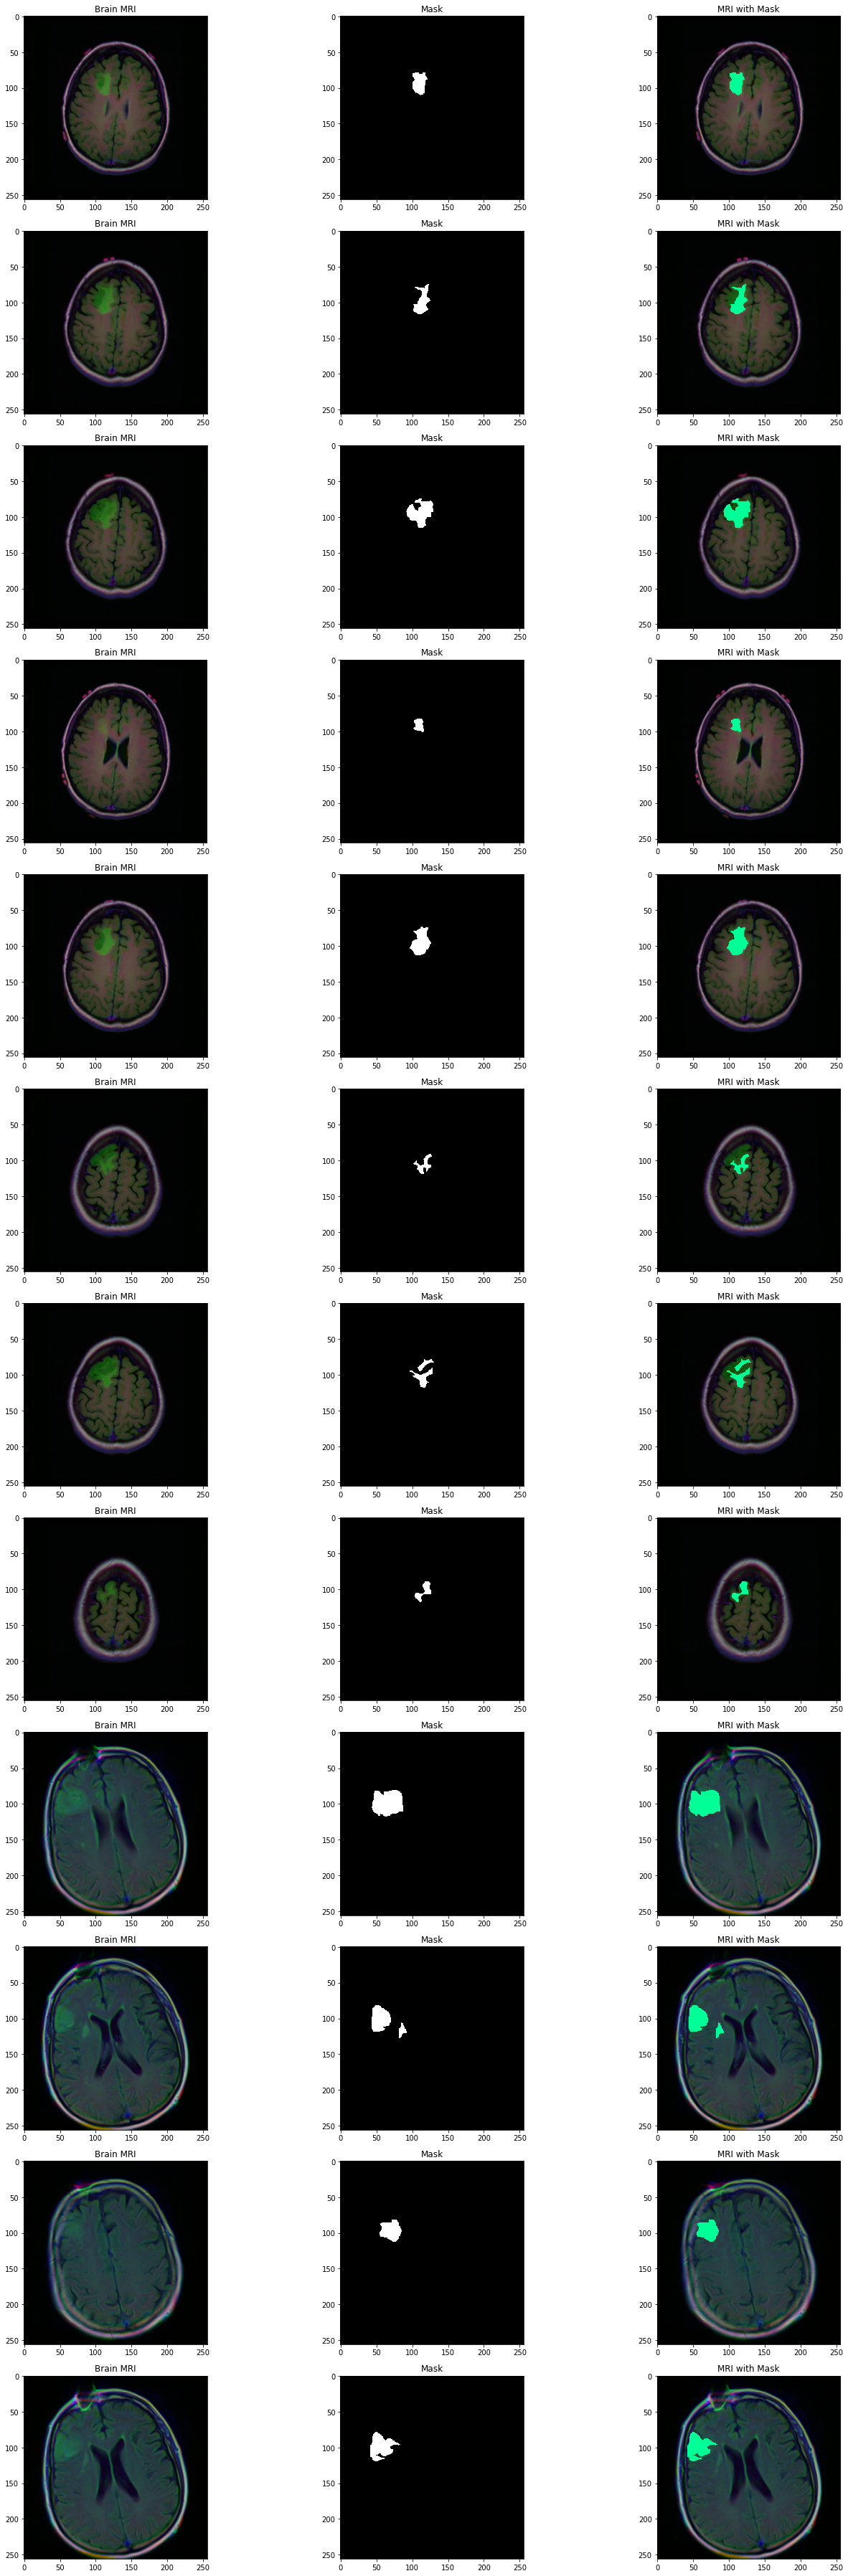

In [48]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

In [49]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [50]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [51]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [52]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [53]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_dir='./', batch_size=16, img_h=256, img_w=256, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Get the number of batches per epoch'
        return int(np.floor(len(self.image_paths)) / self.batch_size)

    def __getitem__(self, index):
        'Generate a batch of data'
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_image_paths = [self.image_paths[i] for i in indexes]
        list_mask_paths = [self.mask_paths[i] for i in indexes]

        X, y = self.__data_generation(list_image_paths, list_mask_paths)
        return X, y

    def on_epoch_end(self):
        'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_image_paths, list_mask_paths):
        'Generate the data corresponding to the indexes in a given batch of images'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        for i in range(len(list_image_paths)):
            image_path = str(list_image_paths[i])
            mask_path = str(list_mask_paths[i])

            image = io.imread(image_path)
            mask = io.imread(mask_path)

            if image is None or mask is None:
                print(f"Warning: Image or mask is empty at path: {image_path}, {mask_path}")
                continue

            try:
                image = cv2.resize(image, (self.img_h, self.img_w))
                image = np.array(image, dtype=np.float64)
                mask = cv2.resize(mask, (self.img_h, self.img_w))
                mask = np.array(mask, dtype=np.float64)
            except cv2.error as e:
                print(f"Error resizing image: {e}")
                print(f"Image path: {image_path}")
                continue

            image -= image.mean()
            image /= image.std()

            mask -= mask.mean()
            mask /= mask.std()

            X[i,] = image
            y[i,] = np.expand_dims(mask, axis=2)

        y = (y > 0).astype(int)
        return X, y

# Example usage:
train_data = DataGenerator(image_paths=train_ids, mask_paths=train_mask)
val_data = DataGenerator(image_paths=val_ids, mask_paths=val_mask)

In [54]:
#model of UNET-VGG16
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output  # Note: block5_conv3 in VGG16

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model
seg_model = build_vgg16_unet((256,256,3))
seg_model.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
_______________________

In [55]:
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [63]:
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)
seg_model.compile(optimizer=adam,
                  loss=focal_tversky,
                  metrics=[tversky]
                 )

# callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20
                             )

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="datasets/weights/Super_UNet_VGG16-segModel-weights.hdf5",
                               verbose=1,
                               save_best_only=True,
                               restore_best_weights=True  # Add this line to restore best weights
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )


In [ ]:
h = seg_model.fit(train_data,
                  epochs=200,
                  validation_data=val_data,
                  callbacks=[checkpointer, earlystopping, reduce_lr],
                  verbose=1  # Add verbose for more information during training
                 )



Epoch 1/200
72/72 [==============================] - 516s 7s/step - loss: 0.4729 - tversky: 0.6295 - val_loss: 0.5523 - val_tversky: 0.5462

Epoch 00001: val_loss improved from inf to 0.55228, saving model to datasets/weights/Super_UNet_VGG16-segModel-weights.hdf5
Epoch 2/200
72/72 [==============================] - 512s 7s/step - loss: 0.4712 - tversky: 0.6306 - val_loss: 0.4922 - val_tversky: 0.6105

Epoch 00002: val_loss improved from 0.55228 to 0.49220, saving model to datasets/weights/Super_UNet_VGG16-segModel-weights.hdf5
Epoch 3/200
 6/72 [=>............................] - ETA: 7:50 - loss: 0.4037 - tversky: 0.7013

In [58]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 5s 840ms/step - loss: 0.7929 - tversky: 0.2656
Segmentation tversky is 26.56%


In [59]:
model_path = "datasets/weights/Super_UNet_VGG16-segModel-weights.hdf5"
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

loaded_model = load_model(model_path, custom_objects={
    'tversky': tversky,
    'focal_tversky': focal_tversky,
    'tversky_loss': tversky_loss
})

In [60]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

def visualize_segmentation_results(model, X_test):
    # Loop through each row in X_test
    for index, row in X_test.head(6).iterrows():
        # Load the image
        img_path = row['image_path']
        img = io.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = np.array(img, dtype=np.float64)
        img -= img.mean()
        img /= img.std()

        # Load the original mask
        orig_mask_path = row['mask_path']
        orig_mask = io.imread(orig_mask_path)
        orig_mask = cv2.resize(orig_mask, (256, 256))

        # Create X array for prediction
        X = np.empty((1, 256, 256, 3))
        X[0, ] = img

        # Make prediction of mask
        predict = model.predict(X)
        pred_mask = np.array(predict).squeeze().round()

        # Plotting the images
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 5, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(orig_mask, cmap='gray')
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(img)
        plt.imshow(orig_mask, alpha=0.5, cmap='jet')
        plt.title('Image with Original Mask')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(img)
        plt.imshow(pred_mask, alpha=0.5, cmap='jet')
        plt.title('Image with Predicted Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


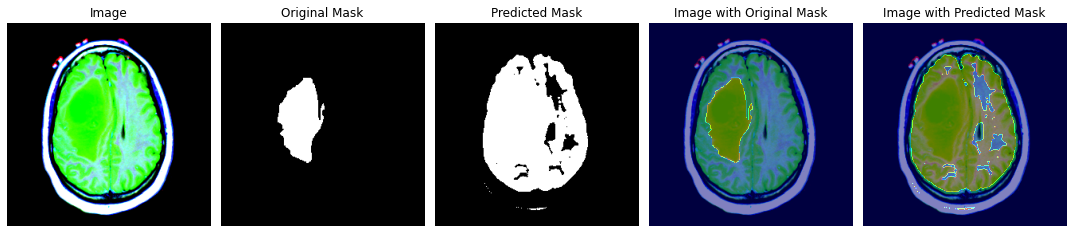

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


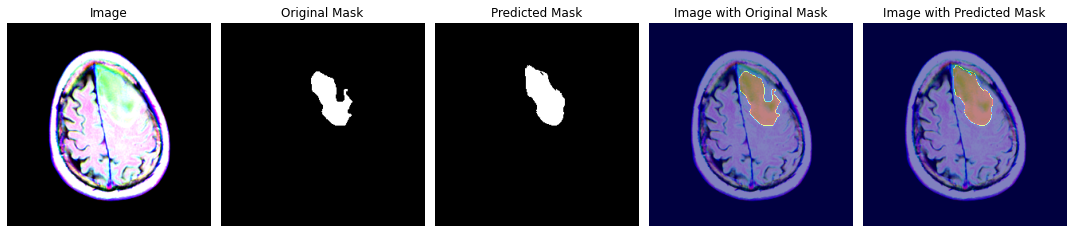

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


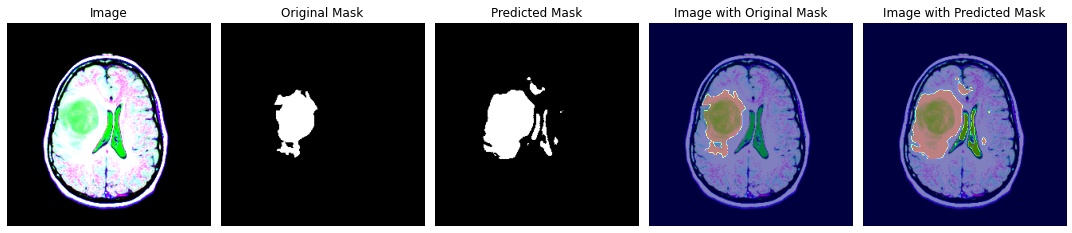

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


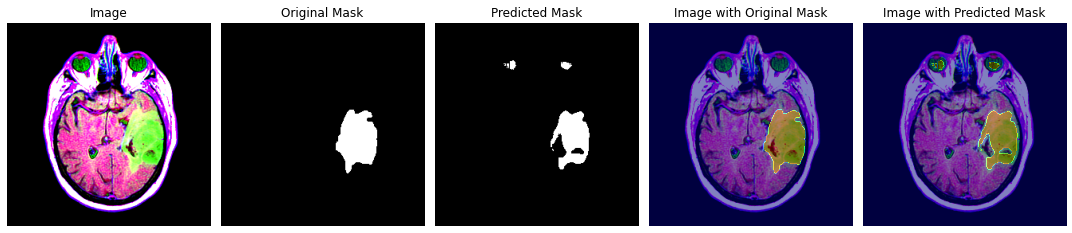

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


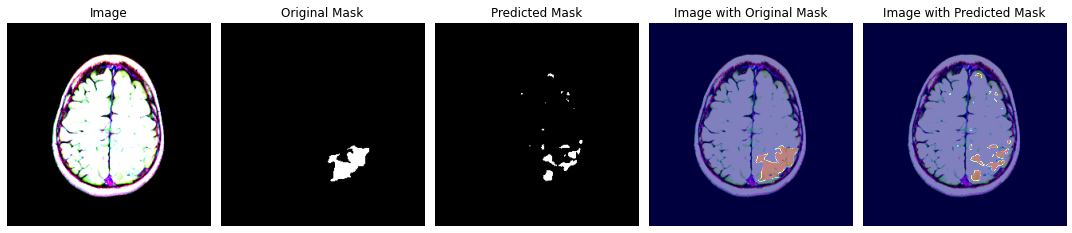

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


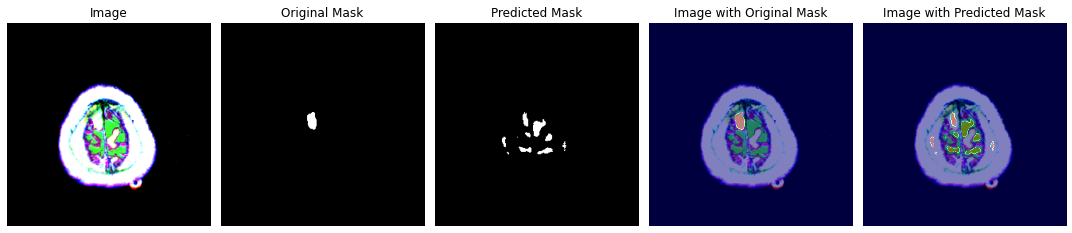

In [61]:
visualize_segmentation_results(loaded_model, X_test)